# Forward model

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
site.addsitedir('..')

In [2]:
import numpy as np
from  matplotlib import pyplot as plt
from src.utils import rand_volume, volume_fourier, volume_comp, mip_z
from src.projection import project, rotate
from src.interpolate import *

### Create volume

Text(0.5, 1.0, 'Volume slice')

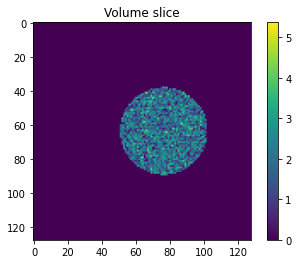

In [3]:
# Create a volume

nx = 128
shape = nx * np.ones(3, dtype=np.int32)
dimensions = 10 * np.ones(3)
radius = 2
centre = np.array([1,0,0])
intensity = 2
sigma = 10

v = rand_volume(shape, dimensions, centre, radius, intensity, sigma)

plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume slice')

Text(0.5, 1.0, 'Volume_comp slice')

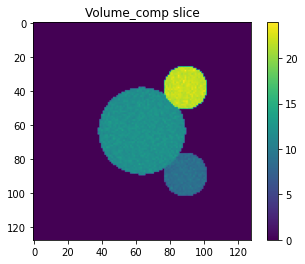

In [4]:
# A volume with components
centres = np.array([[0,0,0], [2, 2, 2], [2, -2, 2]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

v = volume_comp(shape, dimensions, centres, radii, intensities)


mip_z(v)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp slice')

In [6]:
# Take the Fourier transform, rotate 
# and interpolate the new z=0 slice

v_f, X_f, Y_f, Z_f, _, _, _ = volume_fourier(v, dimensions)

#angles = np.array([np.pi/3, np.pi/10, 3*np.pi/4])
angles = np.array([0,0,0])

slice_interp_2d, slice_X, slice_Y, slice_Z = project(v_f, X_f, Y_f,Z_f, angles)

TypeError: get_interpolate_tri_lambda() missing 1 required positional argument: 'vol'

In [ ]:
plt.imshow(np.fft.fftshift(abs(v_f[:,:,int(np.floor(v.shape[2]/2))])))
plt.colorbar()

plt.title('Vol FFT slice')

In [ ]:
iv_f = np.fft.ifftn(v_f)
#plt.imshow(np.real(iv_f[:,:,int(np.floor(v.shape[2]/2))]))
mip_z(np.real(iv_f))
plt.colorbar()

In [ ]:
plt.imshow(np.fft.fftshift(X_f[:,:,0]))
plt.colorbar()
plt.title('X_f coords')

In [ ]:
alpha = np.pi/10
beta = 15*np.pi/3
gamma = 3*np.pi/4
angles = np.array([alpha, beta, gamma])
X_fr, Y_fr, Z_fr = rotate(X_f, Y_f, Z_f, angles)
plt.imshow(np.fft.fftshift(Z_fr[:,:,0]))
#plt.imshow(Z_fr[:,:,0])
plt.colorbar()

In [ ]:
angles = np.array([0,0,0])

slice_interp_2d, slice_X, slice_Y, slice_Z = project(v_f, X_f, Y_f, Z_f, angles)

plt.imshow(np.real(np.fft.ifftn(slice_interp_2d)))
plt.colorbar()

In [ ]:
angles = np.array([-np.pi/2,0,0])

slice_interp_2d, slice_X, slice_Y, slice_Z = project(v_f, X_f, Y_f, Z_f, angles)

plt.imshow(np.real(np.fft.ifftn(slice_interp_2d)))
plt.colorbar()

In [ ]:
a = 'nn'
if a == "nn":
    print('yes')